In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Загрузим тренировочные и тестовые данные
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


In [18]:
# Отсортируем по дате, чтобы потом разделить на трейн/тест по времени
df_train = df_train.sort_values('Deal_date')

# Подготовка данных

In [19]:
# Функция для заполнения пропусков в данных
def fill_missing_data(data: pd.DataFrame):
    # Захешированную информацию по гномам - средним
    for feature in [1, 2, 3]:
        col_name = f"Secret_dwarf_info_{feature}"
        mean_ = data[col_name].mean()
        data[col_name] = data[col_name].fillna(mean_)

    # Регион - самым популярным
    mode_region_value = data["Region"].mode()[0]
    data["Region"] = data["Region"].fillna(mode_region_value)

    # Первую дату дефолта - отдаленным от всех остальных значений "выбросом",
    # например, год перед минимальным значением в датасете

    # min_date_str = data.First_default_date.dropna().min()

    # min_date = datetime.datetime.strptime(min_date_str, "%Y-%m-%d")

    date_for_missing_values = datetime.datetime(2015, 5, 1, 0, 0) - \
                              datetime.timedelta(days=365)

    date_ = str(date_for_missing_values)[:10]

    data["First_default_date"] = data["First_default_date"].fillna(date_)

    # Количество успешных сделок - нулем
    data["Successful_deals_count"] = data["Successful_deals_count"].fillna(0)

    return

In [20]:
# Применим функцию на тренировочных и тестовых данных

fill_missing_data(df_train)
fill_missing_data(df_test)

# Проверим, что пропусков нет

df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [21]:
# Функция для генерации новых признаков


def create_new_features(data):
    # Преобразуем даты в год-месяц-день
    data["First_deal_date"] = pd.to_datetime(data["First_deal_date"])
    data["First_deal_year"] = data["First_deal_date"].apply(lambda x: x.year)
    data["First_deal_month"] = data["First_deal_date"].apply(lambda x: x.month)
    data["First_deal_day"] = data["First_deal_date"].apply(lambda x: x.day)

    data["Deal_date"] = pd.to_datetime(data["Deal_date"])
    data["Deal_year"] = data["Deal_date"].apply(lambda x: x.year)
    data["Deal_month"] = data["Deal_date"].apply(lambda x: x.month)
    data["Deal_day"] = data["Deal_date"].apply(lambda x: x.day)

    data["First_default_date"] = pd.to_datetime(data["First_default_date"])
    data["First_default_year"] = data["First_default_date"].apply(lambda x: x.year)
    data["First_default_month"] = data["First_default_date"].apply(lambda x: x.month)
    data["First_default_day"] = data["First_default_date"].apply(lambda x: x.day)

    # Создадим фичу 'время от первой сделки до первой просрочки' в днях
    data["Difference"] = (data["First_default_date"] - data["First_deal_date"]).dt.days

    # Удалим старые колонки с датами
    data.drop(
        ["First_deal_date", "Deal_date", "First_default_date"], axis=1, inplace=True
    )

    return

In [22]:
# Проверим результат трансформации
create_new_features(df_train)
create_new_features(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,...,First_deal_year,First_deal_month,First_deal_day,Deal_year,Deal_month,Deal_day,First_default_year,First_default_month,First_default_day,Difference
1084,585679,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-3,5,...,2015,2,19,2015,2,24,2014,5,1,-294
1047,5954693,3.935514,-2.299065,5.26729,0.0,Tavern_district_4,7,2.5,-3,5,...,2015,2,14,2015,2,28,2014,5,1,-289
1396,6829250,3.935514,-2.299065,5.26729,2.0,Tavern_district_1,23,2.5,-2,5,...,2015,3,5,2015,3,10,2014,5,1,-308
717,6878449,3.935514,-2.299065,5.26729,2.0,Tavern_district_6,7,2.5,-3,5,...,2015,2,27,2015,3,11,2014,5,1,-302
2877,7185789,3.935514,-2.299065,5.26729,0.0,Tavern_district_3,23,2.5,-2,5,...,2015,2,17,2015,3,17,2014,5,1,-292


# EDA
Рассмотрим на распределение величин по признакам

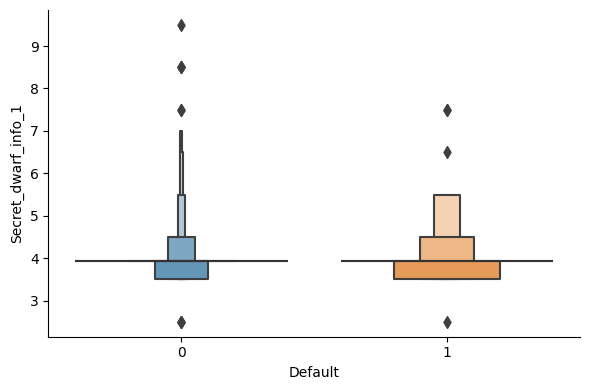

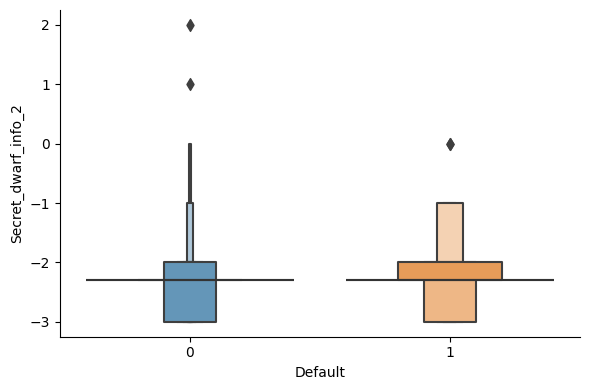

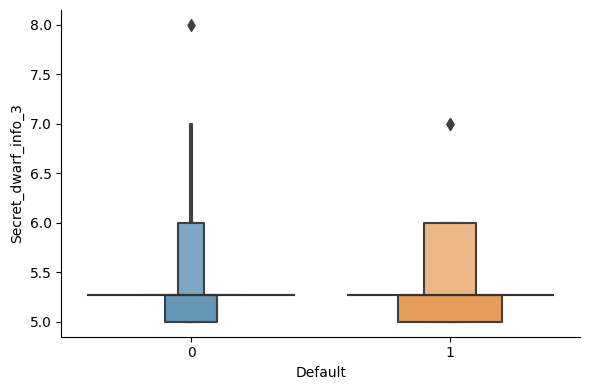

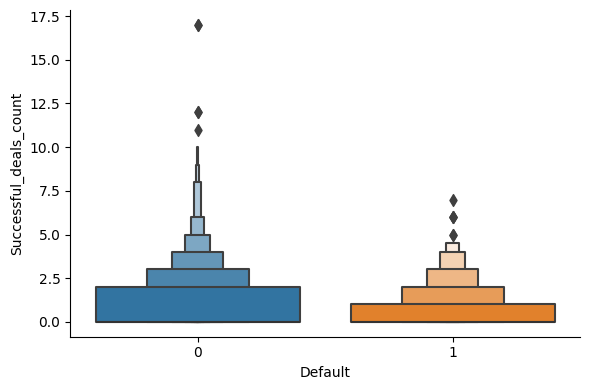

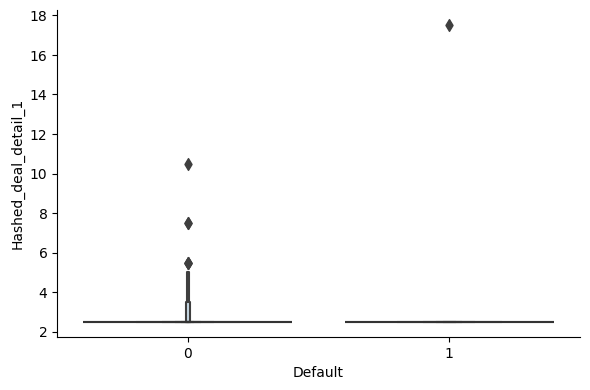

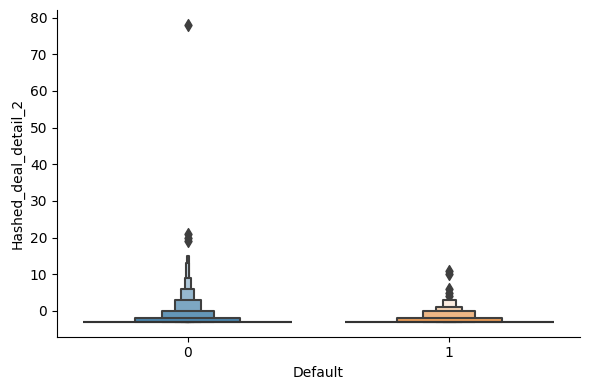

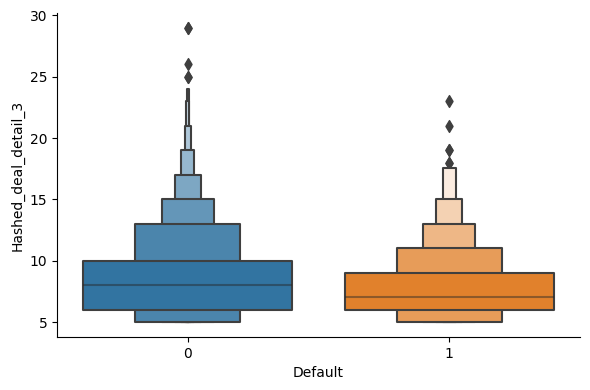

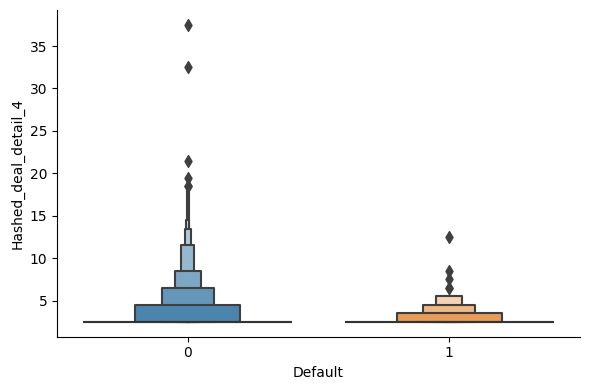

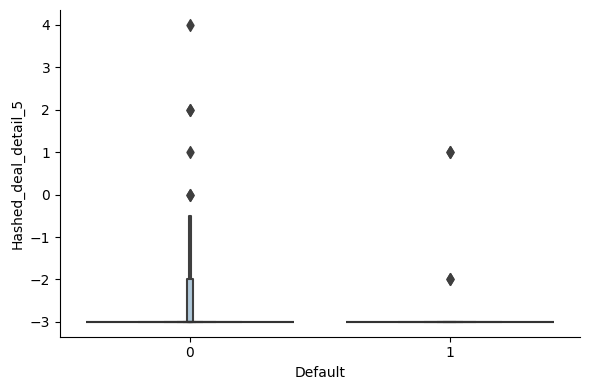

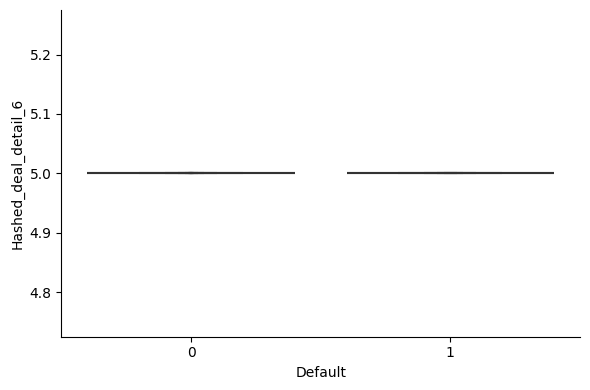

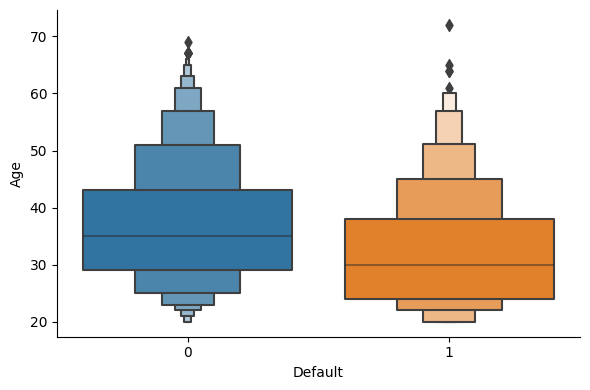

In [23]:
# Интересующие нас ещественные колонки
num_cols = [
    "Secret_dwarf_info_1",
    "Secret_dwarf_info_2",
    "Secret_dwarf_info_3",
    "Successful_deals_count",
    "Hashed_deal_detail_1",
    "Hashed_deal_detail_2",
    "Hashed_deal_detail_3",
    "Hashed_deal_detail_4",
    "Hashed_deal_detail_5",
    "Hashed_deal_detail_6",
    "Age",
]

for col in num_cols:
    sns.catplot(y=col, x="Default", data=df_train, kind="boxen", height=4, aspect=1.5)
plt.show()

In [24]:
df_train['Hashed_deal_detail_6'].nunique()

1

Видно, что `Hashed_deal_detail_6` постоянна для всех клиентов и эту колонку можно удалить.

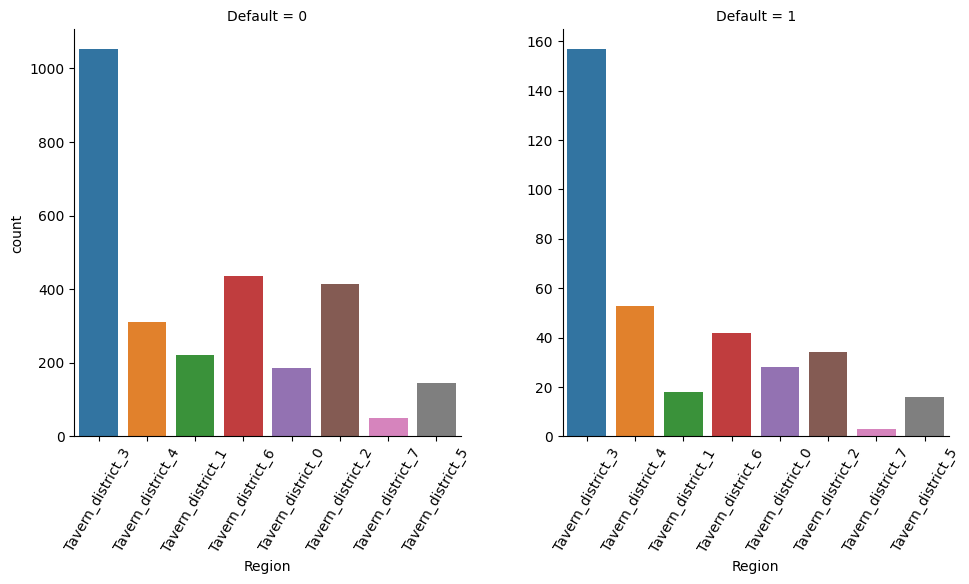

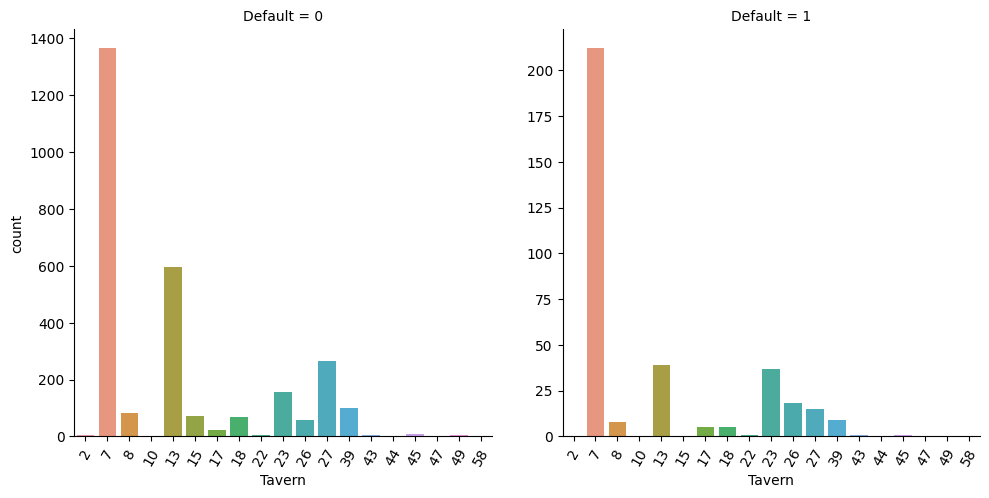

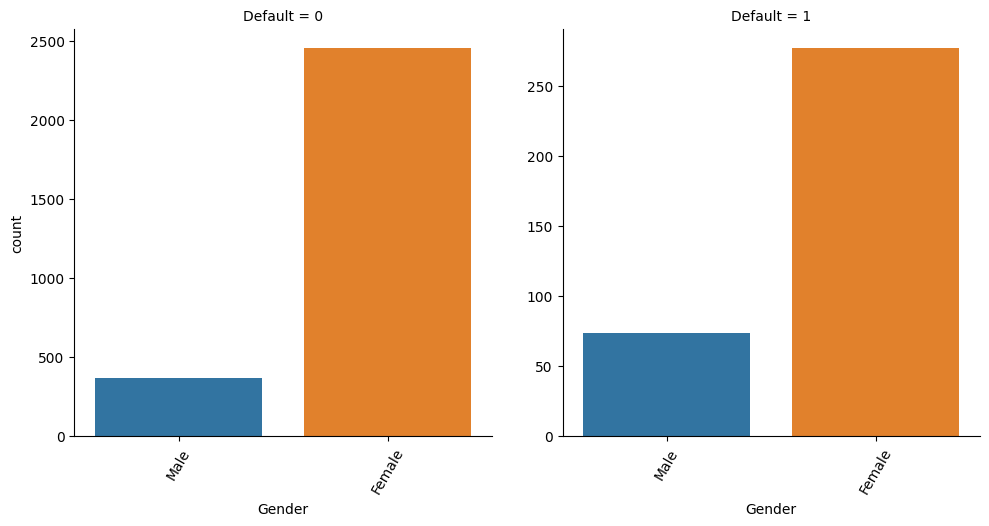

In [25]:
cat_cols = ['Region', 'Tavern', 'Gender']
for col in cat_cols:
    g = sns.catplot(x=col, kind='count', col='Default', data=df_train, sharey=False)
    g.set_xticklabels(rotation=60)

In [26]:
# Функция для обработки категориальных object колонок
# Средние будем считать по тренировочному датасету
# Tavern трансформировать не будем, так как планируем использовать
# композицию деревьев в качестве модели

# mean_region = df_train.groupby('Region')['Default'].mean()

# def transform_object_cols(data, means=mean_region):
    
#     data['Region'] = data['Region'].map(mean_region)
    
#     data['Gender'] = np.where(data['Gender']=='Male', 1, 0)
    
#     # Заодно удалим постоянную колонку
#     data = data.drop('Hashed_deal_detail_6', axis=1)
    
#     return

mean_gender = df_train.groupby('Gender')['Default'].mean()

def transform_object_cols(data, means=mean_gender):
    
    data['Gender'] = data['Gender'].map(mean_gender)
    
    dummy = pd.get_dummies(data.Region, drop_first=True, dtype=int)    
    data.drop('Region', axis=1, inplace=True)
    
    data[dummy.columns] = dummy
    
    return

In [27]:
# Применим функцию

transform_object_cols(df_train)
transform_object_cols(df_test)

df_train.head()

,Deal_id,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,...,First_default_month,First_default_day,Difference,Tavern_district_1,Tavern_district_2,Tavern_district_3,Tavern_district_4,Tavern_district_5,Tavern_district_6,Tavern_district_7
1084,585679,3.935514,-2.299065,5.26729,0.0,23,2.5,-3,5,2.5,...,5,1,-294,0,0,1,0,0,0,0
1047,5954693,3.935514,-2.299065,5.26729,0.0,7,2.5,-3,5,2.5,...,5,1,-289,0,0,0,1,0,0,0
1396,6829250,3.935514,-2.299065,5.26729,2.0,23,2.5,-2,5,2.5,...,5,1,-308,1,0,0,0,0,0,0
717,6878449,3.935514,-2.299065,5.26729,2.0,7,2.5,-3,5,2.5,...,5,1,-302,0,0,0,0,0,1,0
2877,7185789,3.935514,-2.299065,5.26729,0.0,23,2.5,-2,5,2.5,...,5,1,-292,0,0,1,0,0,0,0


# Обучение модели

In [28]:
# Разделим таргеты и фичи

X = df_train.drop(['Default', 'Deal_id'], axis=1)
Y = df_train['Default']

In [29]:
X.shape

(3168, 30)

In [30]:
# Раздлим обущающую выборку на трейн и тест
# Данные отсортированы по дате, чтобы не подглядывать в будущее 
# первые 80% - тренировочная выборка

threshold = int(X.shape[0] * 0.8)
X_train, X_test = X.iloc[:threshold, :], X.iloc[threshold:, :]
y_train, y_test = Y.iloc[:threshold], Y.iloc[threshold:]

X_train.shape

(2534, 30)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier(random_state=472)

model.fit(X, Y)

RandomForestClassifier(random_state=472)

In [32]:
print(f'ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.3f}')
print(f'Точность: {np.sum(y_test == model.predict(X_test)) / y_test.shape[0]:.3f}')

ROC-AUC: 1.000
Точность: 1.000


In [36]:
from catboost import CatBoostClassifier

# cat_cols = ['Tavern', 'Region', 'Gender']
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train)

Learning rate set to 0.015324
0:	learn: 0.6810285	total: 2.07ms	remaining: 2.07s
1:	learn: 0.6683237	total: 3.75ms	remaining: 1.87s
2:	learn: 0.6570059	total: 5.73ms	remaining: 1.9s
3:	learn: 0.6457392	total: 7.68ms	remaining: 1.91s
4:	learn: 0.6342061	total: 9.35ms	remaining: 1.86s
5:	learn: 0.6243499	total: 11.3ms	remaining: 1.86s
6:	learn: 0.6136695	total: 13ms	remaining: 1.85s
7:	learn: 0.6046580	total: 14.8ms	remaining: 1.84s
8:	learn: 0.5949740	total: 16.7ms	remaining: 1.84s
9:	learn: 0.5859403	total: 18.7ms	remaining: 1.85s
10:	learn: 0.5774805	total: 20.6ms	remaining: 1.85s
11:	learn: 0.5690594	total: 22.6ms	remaining: 1.86s
12:	learn: 0.5610774	total: 24.4ms	remaining: 1.85s
13:	learn: 0.5532987	total: 26.4ms	remaining: 1.86s
14:	learn: 0.5454828	total: 28.3ms	remaining: 1.86s
15:	learn: 0.5386007	total: 30.1ms	remaining: 1.85s
16:	learn: 0.5316147	total: 31.8ms	remaining: 1.84s
17:	learn: 0.5237290	total: 33.6ms	remaining: 1.83s
18:	learn: 0.5171377	total: 35.2ms	remaining: 1

In [37]:
print(f'ROC-AUC: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:,1]):.3f}')

ROC-AUC: 0.660


In [33]:
XX_test = df_test.drop(['Deal_id'], axis=1)

submission = df_test['Deal_id'].copy().to_frame()
submission['Prediction'] = model.predict_proba(XX_test)[:, 1]

submission.head()

,Deal_id,Prediction
0,72875713,0.12
1,75825544,0.08
2,81809181,0.19
3,87083256,0.29
4,84651519,0.29


In [34]:
submission.to_csv('prediction.csv', index=False)